In [1]:
#we start by importing all the necessary libraries

import os
import sys
import numpy as np
import pandas as pd
import re
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sktime.forecasting.arima import AutoARIMA
import pandas as pd
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.arima import AutoARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.impute import KNNImputer
from scipy.stats import zscore

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [2]:
#reding and analyzing the data
df = pd.read_csv(filepath_or_buffer="../air-traffic-prediction/parkingLot.csv")
print(df.head())
print(df.shape)

# print(df[df["vehicle_no"].isna()])

  vehicle_no            timestamp  camera_id
0   MHUN7063  2024-09-12 05:00:00          1
1   MHYN4677  2024-09-12 05:00:00          1
2   MHEL6595  2024-09-12 05:00:00          1
3   MHNQ2590  2024-09-12 05:00:00          1
4   MHHA0518  2024-09-12 05:00:00          1
(106694, 3)


### Data Imputation and removing outliers 

- The code processes vehicle entry data from a mall's parking lot by filtering out entries during closed hours
- It imputes missing values using forward fill and applies a rolling mean to smooth daily unique vehicle counts before using KNN imputation for any remaining gaps.
- The daily counts are aggregated by date to obtain the unique vehicle numbers, providing insights into parking lot usage.


### Data Imputation and Filtering

1. Created a complete 20-minute timestamp range with each camera ID, merged it with the original data, and filled missing timestamps.
2. Filtered out data collected during closed hours (12 am to 5 am).
3. Imputed missing vehicle numbers using forward and backward filling, and corrected OCR errors using a regex pattern.
4. Removed duplicate entries with the same timestamp and camera ID.
5. Removing if some vehichle number doesn't follow a given general vehichle regex

In [3]:
def valid_vehicle_no(vehicle_no):
    pattern = r'^[A-Z]{4}[0-9]{4}$'
    return bool(re.match(pattern=pattern, string=vehicle_no))


df['timestamp'] = pd.to_datetime(df['timestamp'])

time_range = pd.date_range(start=df['timestamp'].min(), end=df['timestamp'].max(), freq='20min')
camera_ids = df['camera_id'].unique()
expanded_index = pd.MultiIndex.from_product([time_range, camera_ids], names=['timestamp', 'camera_id'])
df_expanded = pd.DataFrame(index=expanded_index).reset_index()


df = pd.merge(df_expanded, df, on=['timestamp', 'camera_id'], how='left')


mask = ~((df['timestamp'].dt.hour > 0) & (df['timestamp'].dt.hour < 5))
df = df[mask]


df['vehicle_no'] = df['vehicle_no'].ffill().bfill()
df = df[df['vehicle_no'].apply(valid_vehicle_no)]


print(f"Checking if any null values are still present in the data \n\nNumber of Null Values:\n{df.isnull().sum()}")

Checking if any null values are still present in the data 

Number of Null Values:
timestamp     0
camera_id     0
vehicle_no    0
dtype: int64


### Merging 

Now we merge the vehichles captured by the camera1 and canera2 into a complete database
identifying on each day when a vehicle entered the mall and exited the mall in the dataframe 
called merged_data, and assuring the following in the merged_data:

- A vehicles exit time > it's entry time
- A vehicle enters and exits the mall in the same day(to avoid huge outliers caused due to missing NA's having difference of multiple days    which does not make sense in a general sense in a real scenario )

In [4]:

camera_1 = df[df['camera_id'] == 1]
camera_2 = df[df['camera_id'] == 2]


merged_data = pd.merge(camera_1, camera_2, on='vehicle_no', suffixes=('_entry', '_exit'))

# Convert 'timestamp_entry' and 'timestamp_exit' to datetime
merged_data['timestamp_entry'] = pd.to_datetime(merged_data['timestamp_entry'])
merged_data['timestamp_exit'] = pd.to_datetime(arg=merged_data['timestamp_exit'])

# Ensure timestamps are on the same date by comparing just the date part
merged_data = merged_data[
    (merged_data['timestamp_entry'].dt.date == merged_data['timestamp_exit'].dt.date) &
    (merged_data['timestamp_entry'] <= merged_data['timestamp_exit'])
]

### Data Smoothing and Outlier removing for the average daily count problem(1A)

- A DataFrame is created from `daily_counts`, resetting the index and renaming the columns to `date` and `unique_vehicle_count`.
- A rolling mean is calculated over a window of 3 days to smooth the unique vehicle counts, resulting in a new column called `smoothed_counts`.
- The Z-score method is applied to the smoothed counts to identify and remove outliers, retaining only those counts within ±3 standard deviations.


In [5]:
daily_counts = merged_data.groupby(merged_data['timestamp_entry'].dt.date)['vehicle_no'].nunique()

daily_counts_df = pd.DataFrame(data=daily_counts).reset_index()

daily_counts_df.columns = ['date', 'unique_vehicle_count']
daily_counts_df['smoothed_counts'] = daily_counts_df['unique_vehicle_count'].rolling(window=3, min_periods=1).mean()

daily_counts_df['z_scores'] = zscore(daily_counts_df['smoothed_counts'])
daily_counts_df = daily_counts_df[(daily_counts_df['z_scores'] < 3) & (daily_counts_df['z_scores'] > -3)]

daily_counts_df.drop(columns=['z_scores'], inplace=True)
daily_counts_df = pd.Series(daily_counts_df['smoothed_counts'].values, index=daily_counts_df['date'])

In [6]:

import warnings
warnings.filterwarnings("ignore")

# adapted from https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python
def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, loc=(1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

### Analyzing
Now we analyze the data on multiple parameters:
- The Augmented Dickey–Fuller unit test examines if the time series is non-stationary
- The ACF and PACF values for different lags to examining the data and predict the Auto Regerssive and Moving average terms

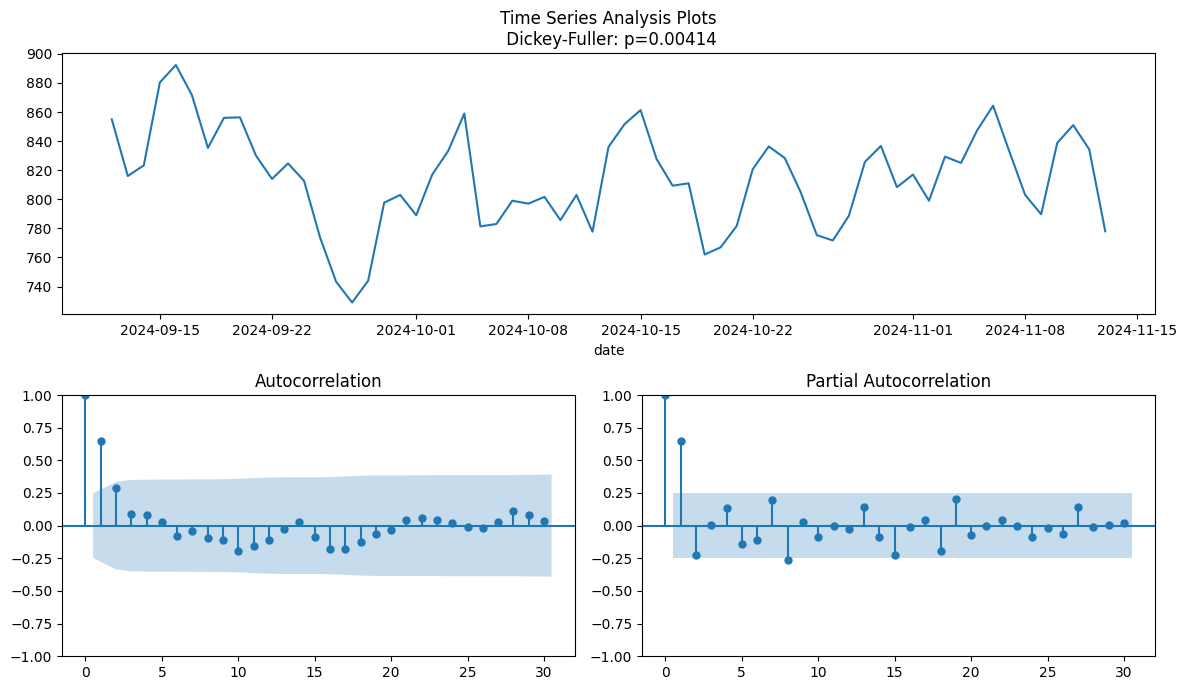

In [7]:
tsplot(daily_counts_df, lags = 30)

## Analysis
On analyzing the above data we see the p value = 0.00414 ,
- a low enough p value indicating that the series is almost stationary 
- this happened for the series itself implying d = 0 , 
- also the ACF seems to be majorly sinusodial and a PACF with significant values upto lag 2 and then 0, suggesting an AR model 
- not significant, yet small amount of seasonality is given in the data 

Thus, while training we will keep set **d = 0**, the AR term to be **1 < p <= 3** , the MA term to be **0 < q <= 3** , and the **seasonality = 14** days 


Also we forecast using another fixed ARIMA(2,0,0) with seasonality = 14 along with the trained autoARIMA

In [8]:
warnings.filterwarnings("ignore")


y = pd.DataFrame(data=daily_counts_df, index=pd.to_datetime(arg=daily_counts.index))

y_train, y_test = temporal_train_test_split(y, test_size=7)
y_train.index.freq = 'D'
y_test.index.freq = 'D'

#fitting the model using AUTO ARIMA
model = AutoARIMA( start_q = 0 , max_q = 2 ,d = 0 , start_P=2 , max_P=4 , sp=14)
model.fit(y_train)

y_pred = model.predict(fh=np.arange(1, 8))

#forecasting using fixed parameters for the SARIMAX model ARIMA(0,0,0) with a seasonality of 14 as inferreed from the various plots
sarimax_model = SARIMAX(endog=y_train, order=(2, 0,0), seasonal_order=(1, 1, 2, 14))
sarimax_result = sarimax_model.fit(disp=False)

#forecasting
y_pred_sarima = sarimax_result.forecast(steps=7)

In [9]:
def mean_absolute_scaled_error(y_true, y_pred):

    mae = mean_absolute_error(y_true, y_pred)

    # Calculate the naive forecast errors
    naive_forecast = np.roll(y_true.astype(float), 1)  # Ensure it's float
    naive_forecast[0] = np.nan  # First value has no naive forecast
    naive_error = np.abs(y_true - naive_forecast)

    # Calculate the mean absolute error of the naive forecast (MAE)
    mae_naive = np.nanmean(naive_error)  # Ignore NaN values in the calculation
    
    # Calculate MASE
    mase = mae / mae_naive if mae_naive != 0 else np.nan  # Handle division by zero
    
    return mase

In [10]:

mase = mean_absolute_scaled_error(y_true=y_test, y_pred=y_pred)
mase_s = mean_absolute_scaled_error(y_true=y_test, y_pred=y_pred_sarima)
y_pred_sarima = sarimax_result.forecast(steps=7)


mape = mean_absolute_percentage_error(y_test, y_pred)
mape_s = mean_absolute_percentage_error(y_test, y_pred_sarima)


print(f"MASE uisng autoARIMA: {mase:.4f}")    
print(f"MAPE using autoARIMA: {mape * 100:.2f}%")  

print(f"MASE using SARIMAX: {mase_s:.4f}")    
print(f"MAPE using SARIMAX: {mape_s * 100:.2f}%")  

MASE uisng autoARIMA: 0.9825
MAPE using autoARIMA: 3.57%
MASE using SARIMAX: 0.7080
MAPE using SARIMAX: 2.60%


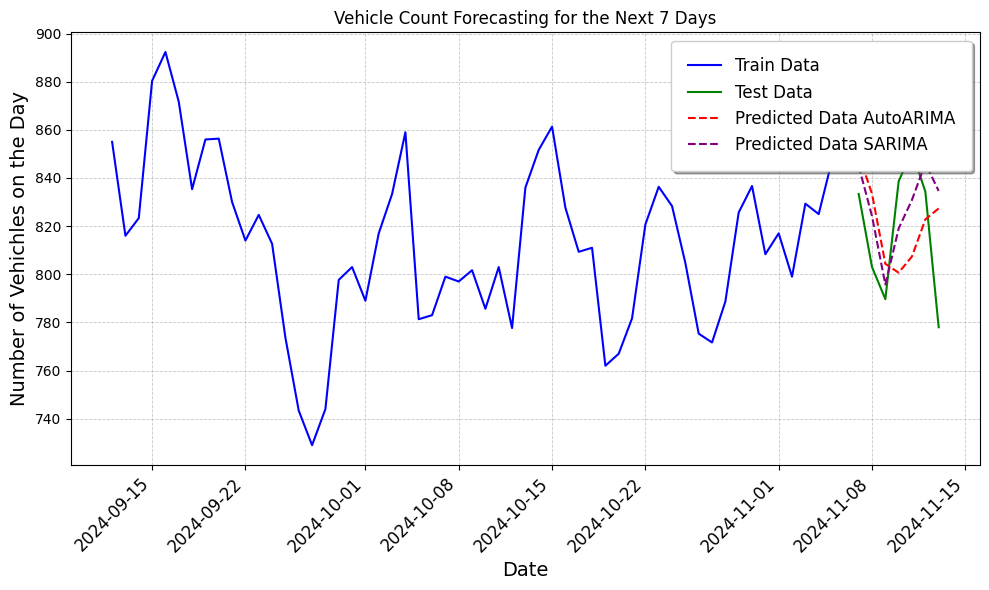

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label="Train Data", color='blue')
plt.plot(y_test.index, y_test, label="Test Data", color='green')

future_dates = pd.date_range(start=y.index[-8] + pd.Timedelta(days=1), periods=7)
plt.plot(future_dates, y_pred, label="Predicted Data AutoARIMA", color='red', linestyle='--')
plt.plot(future_dates, y_pred_sarima, label="Predicted Data SARIMA", color='purple', linestyle='--')

plt.title('Vehicle Count Forecasting for the Next 7 Days')
plt.xlabel(xlabel='Date', fontsize=14)
plt.ylabel('Number of Vehichles on the Day', fontsize=14)

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.6, alpha=0.7)


plt.legend(loc='upper right', fontsize=12, frameon=True, shadow=True, borderpad=1)
plt.tight_layout()
plt.show()

### Data Smoothing and Outlier removing for the average time spent problem(1B)

- **Time Calculation**: It computes the time spent by each vehicle in hours based on entry and exit timestamps and takes the average time spent for vehicles on that day

- **Smoothing and Outlier Removal**: A rolling mean is applied to smooth the data, and Z-scores are used to identify and remove outliers beyond 3 standard deviations

- **Conversion to Time Series**: The cleaned average time spent data is converted back into a time series format for further analysis


In [12]:
warnings.filterwarnings(action="ignore")

merged_data['time_spent'] = (merged_data['timestamp_exit'] - merged_data['timestamp_entry']).dt.total_seconds() / 3600  # convert to hours

avg_time_spent = merged_data.groupby(by=merged_data['timestamp_entry'].dt.date)['time_spent'].mean()

avg_time_spent_df = avg_time_spent.reset_index()
avg_time_spent_df.columns = ['date', 'avg_time_spent']

avg_time_spent_df['smoothed_avg_time_spent'] = avg_time_spent_df['avg_time_spent'].rolling(window=3, min_periods=1).mean()

avg_time_spent_df['z_scores'] = zscore(avg_time_spent_df['smoothed_avg_time_spent'])
avg_time_spent_df = avg_time_spent_df[(avg_time_spent_df['z_scores'] < 3) & (avg_time_spent_df['z_scores'] > -3)]

avg_time_spent_df.drop(columns=['z_scores'], inplace=True)

avg_time_spent = pd.Series(avg_time_spent_df['smoothed_avg_time_spent'].values, index=avg_time_spent_df['date'])

In [13]:
warnings.filterwarnings("ignore")

# adapted from https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python
def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

### Analyzing
Now we analyze the data on multiple parameters:
- The Augmented Dickey–Fuller unit test examines if the time series is non-stationary
- The ACF and PACF values for different lags to examining the data and predict the Auto Regerssive and Moving average terms

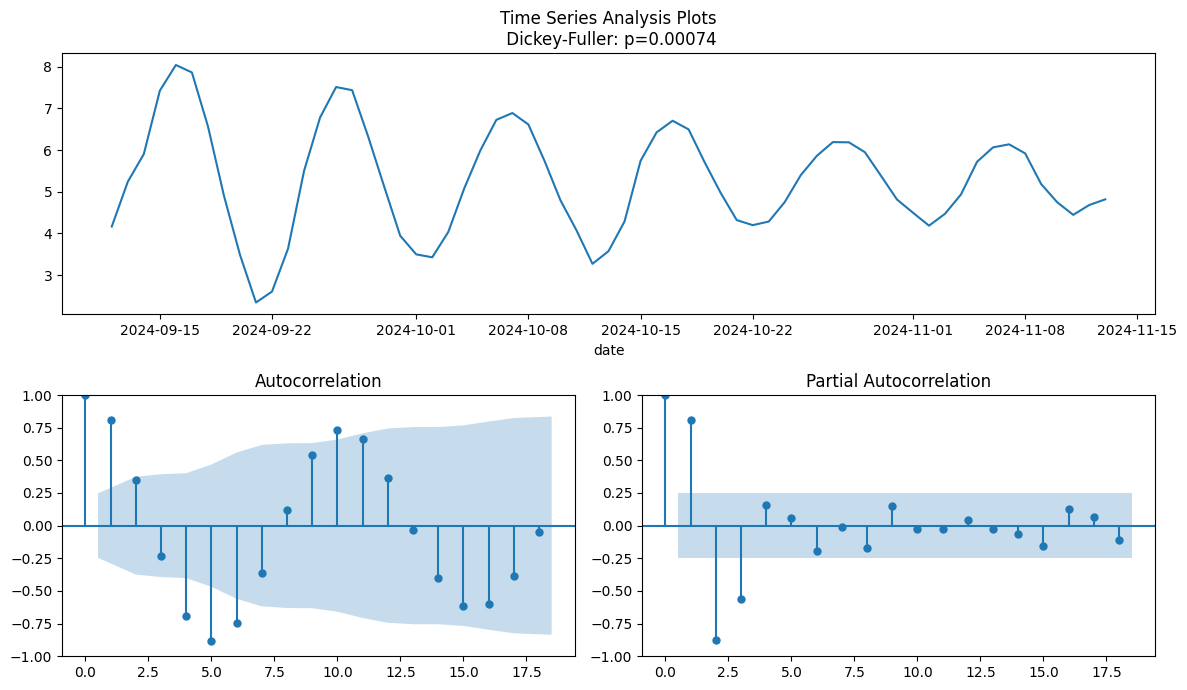

In [14]:
tsplot(avg_time_spent)

## Analysis
On analyzing the above data we see the p value = 0.00074 a very small value indicating the data is stationary further:
- this happened for the series itself implying d = 0 , 
- also seeing that the ACF is sinusodial and the PACF values are significant upto lag 4 and drop immediately after that suggest and AR 4 model
- also clearly the data has some seasonality every 14 days 

Thus, while training we will keep set **d = 0**, the AR term to be **2 < p <= 5** , the MA term to be **0 <= q <= 2** , and the **seasonality = 14** days 


Also we forecast using another fixed ARIMA(4,0,0) with seasonality = 14 along with the trained autoARIMA

In [15]:
warnings.filterwarnings("ignore")
y_time = pd.DataFrame(data=avg_time_spent, index=pd.to_datetime(avg_time_spent.index))

y_train_time, y_test_time = temporal_train_test_split(y_time, test_size=7)

#fitting the model using AUTO ARIMA
model_time = AutoARIMA(start_P = 3 , max_P = 5, start_q= 0 , max_q = 2 , d = 0 , suppress_warnings=True, seasonal=True , sp = 14)
model_time.fit(y=y_train_time)

y_pred_time = model_time.predict(fh=np.arange(1, 8))


#forecasting using fixed parameters for the SARIMAX model ARIMA(4,0,0) with a seasonality of 14 as inferreed from the various plots

sarimax_model = SARIMAX(endog=y_train_time, order=(4,0,0), seasonal_order=(1,1,2,14) ) 
sarimax_result = sarimax_model.fit(disp=False)
y_pred_time_sarima = sarimax_result.forecast(steps=7)

In [16]:
def mean_absolute_scaled_error(y_true, y_pred):

    mae = mean_absolute_error(y_true, y_pred)

    # Calculate the naive forecast errors
    naive_forecast = np.roll(y_true.astype(float), 1)  # Ensure it's float
    naive_forecast[0] = np.nan  # First value has no naive forecast
    naive_error = np.abs(y_true - naive_forecast)

    # Calculate the mean absolute error of the naive forecast (MAE)
    mae_naive = np.nanmean(naive_error)  # Ignore NaN values in the calculation
    
    # Calculate MASE
    mase = mae / mae_naive if mae_naive != 0 else np.nan  # Handle division by zero
    
    return mase

In [17]:
mase = mean_absolute_scaled_error(y_true=y_test_time, y_pred=y_pred_time)
mase_s = mean_absolute_scaled_error(y_true=y_test_time, y_pred=y_pred_time_sarima)


mape = mean_absolute_percentage_error(y_test_time, y_pred_time)
mape_s = mean_absolute_percentage_error(y_test_time, y_pred_time_sarima)

print(f"MASE uisng autoARIMA: {mase:.4f}")    
print(f"MAPE using autoARIMA: {mape * 100:.2f}%")  

print(f"MASE using SARIMAX: {mase_s:.4f}")    
print(f"MAPE using SARIMAX: {mape_s * 100:.2f}%")  

MASE uisng autoARIMA: 0.4901
MAPE using autoARIMA: 3.36%
MASE using SARIMAX: 0.3653
MAPE using SARIMAX: 2.53%


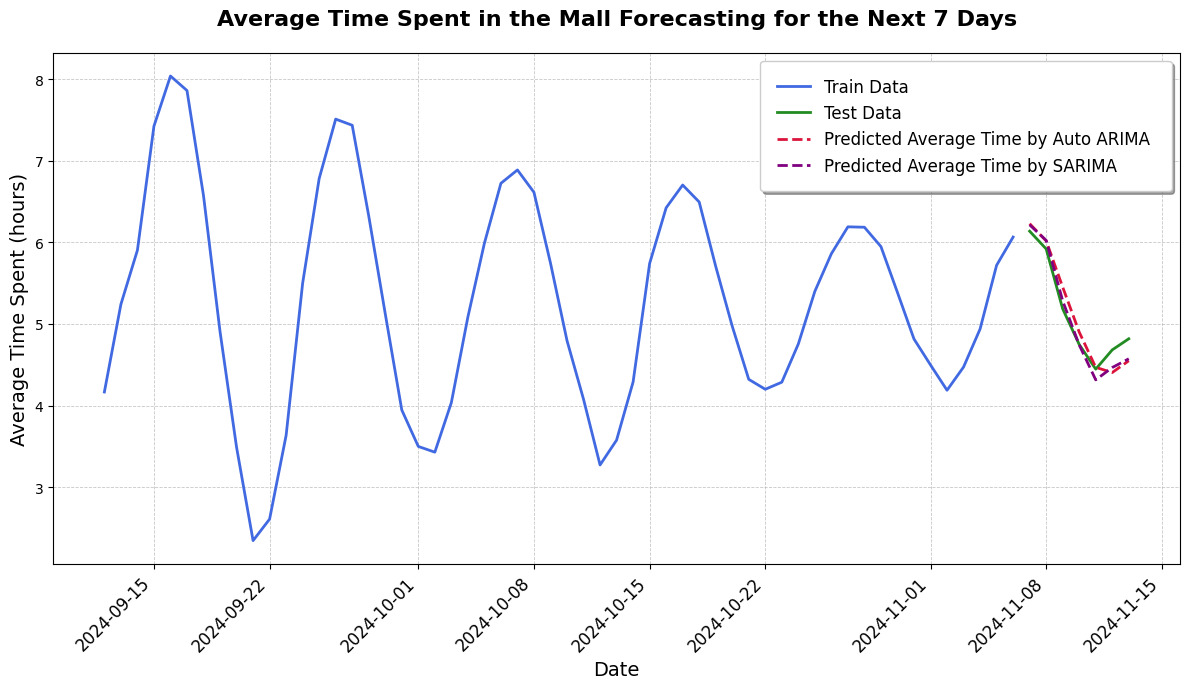

In [18]:
plt.figure(figsize=(12, 7))

plt.plot(y_train_time.index, y_train_time, label="Train Data", color='royalblue', linewidth=2)
plt.plot(y_test_time.index, y_test_time, label="Test Data", color='forestgreen', linewidth=2)

future_dates_time = pd.date_range(start=y_time.index[-8] + pd.Timedelta(days=1), periods=7)
plt.plot(future_dates_time, y_pred_time, label="Predicted Average Time by Auto ARIMA ", color='crimson', linestyle='--', linewidth=2)
plt.plot(future_dates_time, y_pred_time_sarima, label="Predicted Average Time by SARIMA", color='purple', linestyle='--', linewidth=2)


plt.title('Average Time Spent in the Mall Forecasting for the Next 7 Days', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Time Spent (hours)', fontsize=14)

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.7)

plt.legend(loc='upper right', fontsize=12, frameon=True, shadow=True, borderpad=1)
plt.tight_layout()

plt.show()